In [2]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-07-10 09:43:31,382: Credentials are already in use. The existing account in the session will be replaced.


# Twirler ( for later Use)

In [35]:
import re #because we need regular expressions
import numpy as np #because we need the random number generator
from qiskit import *
from qiskit.tools.monitor import job_monitor

import sys
sys.path.append('../')

from qiskit.aqua.utils import *

import numpy as np

Pauligateset=['id','x','y','z']

def equal(A, B, tolerance=1E-6, allowPhaseCheck=True):
    """
    Returns True if A and B are equal within tolerance tol, element-wise
    :param A: nxm matrix
    :param B: nxm matrix
    :param tolerance: Tolerance
    :param allowPhaseCheck: True if A and B should be considered equal if they are equal up to a complex phase factor
    :raises ValueError: if A, B not correct shape
    :return: True or False
    """
    dim0 = A.shape[0]
    dim1 = A.shape[1]
    if len(A.shape) > 2 or len(B.shape) > 2:
        raise ValueError("Both arguments must be n x m matrices.")
    if dim0 != B.shape[0] or dim1 != B.shape[1]:
        raise ValueError("Arguments must be of equal dimension.")

    checkPhase = False

    for ind in range(dim0):
        if checkPhase:
            break
        for j in range(dim1):
            num = np.absolute(A[ind, j] - B[ind, j])
            if num > tolerance:
                if allowPhaseCheck:
                    checkPhase = True  # There might be a (global) phase difference between the matrices
                else:
                    return False
                break

    if checkPhase:# Handle the case A = e^(i * theta) * B
        first = True
        eiPhase = 1

        for ind in range(dim0):
            for j in range(dim1):
                A_ij = A[ind, j]
                B_ij = B[ind, j]

                if np.absolute(A_ij) < tolerance:
                    A_ij = 0
                if np.absolute(B_ij) < tolerance:
                    B_ij = 0

                if A_ij == 0 and B_ij == 0:
                    continue
                elif (A_ij == 0 and B_ij != 0) or (A_ij != 0 and B_ij == 0):
                    # If one is zero, multiplying by phase factor does not change anything.
                    # Therefore, the other must be zero for the matrices to be equal up to a phase factor.
                    return False

                rel = A_ij / B_ij
                if np.absolute(np.absolute(rel) - 1) > tolerance:  # a/b must be 1.000... * e^(i * theta)
                    return False
                if first:
                    first = False
                    eiPhase = rel  # e ^(i * theta)
                if np.absolute(eiPhase - rel) > tolerance:
                    return False
    return True

def getPaulitwirlingPairsCX(printpairs=False):
    
    #making the gates
    
    ID1q = np.array([[1, 0], [0, 1]], dtype=np.complex_)
    sigmaX = np.array([[0, 1], [1, 0]], dtype=np.complex_)
    sigmaY = np.array([[0, 0 - 1.0j], [0 + 1.0j, 0]], dtype=np.complex_)
    sigmaZ = np.array([[1, 0], [0, -1]], dtype=np.complex_)

    ID2q = np.kron(ID1q, ID1q)

    tol = 1E-8

    paulis = np.array([ID1q, sigmaX, sigmaY, sigmaZ], dtype=np.complex_)

    cX = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]], dtype=np.complex_)
    
    #some kind of new array

    pairs = np.zeros((4, 4, 2), dtype=int)
    
    #making all possible configurations for twirling (gates a,b,c,d)

    for a in range(4):  # sigma_control ^a
        pauli_ca = paulis[a]
        for b in range(4):  # sigma_target ^b
            pauli_tb = paulis[b]
            for c in range(4):  # sigma_control ^c
                pauli_cc = paulis[c]
                for d in range(4):  # sigma_target ^d
                    pauli_td = paulis[d]
                    LHS = np.kron(pauli_cc, pauli_td)
                    RHS = cX @ np.kron(pauli_ca, pauli_tb) @ cX.transpose().conjugate()
                    if equal(LHS, RHS, tol):
                        if printpairs:
                            print(Pauligateset[a],Pauligateset[b],Pauligateset[c],Pauligateset[d])
                        pairs[a][b][0] = c
                        pairs[a][b][1] = d
    return pairs

twirlingPairs = getPaulitwirlingPairsCX()

def create_Paulitwirled_and_noiseamplified_circuit(circuit,r,two_error_map,paulitwirling=True,controlledgatename='cx'):
    '''Pauli-twirl and amplify noise of controlled gates in a circuit
    Args:
        circuit: the original circuit
        r: noise amplification factor
        two_error_map: map of error rates of controlled gate between two qubits
        paulitwirling: turn Pauli-twirling on or off
        controlledgatename: name of the controlled gate to apply Pauli-twirling and error amplification to
    Returns:
        new circuit that is Pauli-twirled and errors are amplified by a factor for r
    '''
    newqasm_str=""
    qs=circuit.qasm()
    qregname=circuit.qregs[0].name
    for line in iter(qs.splitlines()):
        if line.startswith(controlledgatename):
            ## Find the number of the control and the target qubit
            search_results = re.finditer(r'\[.*?\]', line)
            count=0
            for item in search_results:
                if count==0:
                    control_ind=int(item.group(0).lstrip('[').rstrip(']'))
                else:
                    target_ind=int(item.group(0).lstrip('[').rstrip(']'))
                count+=1
            ## Apply Pauli-twirling
            if paulitwirling:
                indices_ab = np.random.randint(0, 4, 2)
                indices_cd = twirlingPairs[indices_ab[0]][indices_ab[1]]

                if indices_ab[0]>0:
                    newqasm_str+=Pauligateset[indices_ab[0]]+" "+qregname+"["+str(control_ind)+"];\n"
                if indices_ab[1]>0:
                    newqasm_str+=Pauligateset[indices_ab[1]]+" "+qregname+"["+str(target_ind)+"];\n"
                    
                newqasm_str+=line+"\n"
                
                if indices_cd[0]>0:
                    newqasm_str+=Pauligateset[indices_cd[0]]+" "+qregname+"["+str(control_ind)+"];\n"
                if indices_cd[1]>0:
                    newqasm_str+=Pauligateset[indices_cd[1]]+" "+qregname+"["+str(target_ind)+"];\n"
            else:
                newqasm_str+=line+"\n"

            ## increase the error rate of a cx gate
            if np.random.uniform(0, 1) < (r - 1) * two_error_map[control_ind][target_ind]:
                ### we need to avoid that the indentity is drawn for the control and the target qubit at the same time
                ### there are 4x4 combinations
                # I I    X I    Y I    Z I
                # I X    X X    Y X    Z X
                # I Y    X Y    Y Y    Z Y
                # I Z    X Z    Y Z    Z Z
                # with global indexation for random numbers
                # 0      4      8      12
                # 1      5      9      13
                # 2      6      10     14
                # 3      7      11     15
                # and local indexation
                # 0,0    1,0    2,0    3,0
                # 0,1    1,1    2,1    3,1
                # 0,2    1,2    2,2    3,2
                # 0,3    1,3    2,3    3,3
                # so we make sure to never draw 0 = (0,0) = I I
                ind_ef = np.random.randint(1, 16, 1)
                ind_e=int(int(ind_ef[0])/4)
                ind_f=ind_ef[0]%4
                if ind_e>0:
                    newqasm_str+=Pauligateset[ind_e]+" "+qregname+"["+str(control_ind)+"];\n"
                if ind_f>0:
                    newqasm_str+=Pauligateset[ind_f]+" "+qregname+"["+str(target_ind)+"];\n"

        else:
            newqasm_str+=line+"\n"
    circ=QuantumCircuit().from_qasm_str(newqasm_str)
    return circ

def Richardson_extrapolate(E, c):
    n=E.shape[0]
    if c.shape[0] != n:
        raise ValueError('E and c must have the same dimension.')
    if n<=1:
        raise ValueError('the dimension of E and c must be larger than 1.')
    A = np.zeros((n,n))
    b = np.zeros((n,1))
    #must sum to 1
    A[0,:] = 1
    b[0] = 1
    for k in range(1,n):
        A[k,:] = c**k
    x=np.linalg.solve(A,b)
    return np.dot(np.transpose(E),x)

def mitigate(circuit, amplification_factors,\
             expectationvalue_fun,\
             execution_backend, \
             experimentname, cx_error_map,\
             num_shots, num_experiments,\
             target_backend=None, noise_model=None, basis_gates=None,\
             paulitwirling=True, verbose=True):
    """
    it is of utter most importance, that the circit is executable on the backend that it is to be executed/targeted for
    target_backend: is used if execution_backend is a simulator
    noisemodel: is used if execution_backend is a simulator
    this function is implemented with convenience in mind, the classical part can be trivially made more memory efficient
    """
    optimization_level=1

    n_qubits = execution_backend.configuration().n_qubits
    is_simulator = execution_backend.configuration().simulator

    max_depth_dict={}
    mean_depth_dict={}
    max_depth_transpiled_dict={}
    mean_depth_transpiled_dict={}
    jobs_dict={}
    E_dict={}
    E_av_dict={}
    result_dict={}

    ### sanity checks
    if len(amplification_factors)<2:
        raise ValueError("specify at least 2 amplification factors, e.g., (1,2) ")
    if is_simulator:
        if target_backend == None:
            raise ValueError("you need to specify a taget backend")
        if noise_model == None:
            raise ValueError("you need to specify a noise model")
        if basis_gates == None:
            raise ValueError("you need to specify basis gates")
    else:
        execution_backend = target_backend

    if verbose:
        print("Sanity checks passed")

    if is_simulator:
        # in the case of a simulator,
        # we do not need to split the runs,
        # because max_experiments is not limited
        experimentname+="_backend"+execution_backend.name()
        experimentname+="_noisemodel"+target_backend.name()
        experimentname+="_shots"+str(num_shots)
        experimentname+="_experiments"+str(num_experiments)
        experimentname+="_paulitwirling"+str(paulitwirling)
        for r in amplification_factors:
            name=experimentname+"_r"+str(r)
            result_dict[name] = read_results(name)
            if verbose:
                if result_dict[name] == None:
                    print("Could not read result for job '",name, "' from disk")
                else:
                    print("Result for job '",name, "' successfully read from disk")

            ### read circuit depth statistics from file
            if not result_dict[name] == None:
                with open('results/'+name+'.mean_circuit_depth','r') as f:
                    mean_depth_dict[name]=float(f.read())
                with open('results/'+name+'.max_circuit_depth','r') as f:
                    max_depth_dict[name]=float(f.read())
                with open('results/'+name+'.mean_transpiled_circuit_depth','r') as f:
                    mean_depth_transpiled_dict[name]=float(f.read())
                with open('results/'+name+'.max_transpiled_circuit_depth','r') as f:
                    max_depth_transpiled_dict[name]=float(f.read())

        for r in amplification_factors:
            name=experimentname+"_r"+str(r)
            if not result_dict[name] == None:
                continue
            mean_depth=0
            max_depth=0
            mean_depth_transpiled=0
            max_depth_transpiled=0
            circuits_r=[]
            for p in range(1,num_experiments+1):
                if verbose and p%25==0:
                    print("Creating circuits for '",name, "'", p, "/",num_experiments, end='\r')
                circ_tmp = create_Paulitwirled_and_noiseamplified_circuit(\
                                    circuit, r, cx_error_map, paulitwirling)
                depth = circ_tmp.depth()
                mean_depth += depth
                max_depth = max(max_depth,depth)
                # now we can transpile to combine single qubit gates, etc.
                circ_tmp_transpiled=transpile(circ_tmp,\
                                              backend=target_backend,\
                                              optimization_level=optimization_level)
                circuits_r.append(circ_tmp_transpiled)
                depth=circ_tmp_transpiled.depth()
                mean_depth_transpiled += depth
                max_depth_transpiled = max(max_depth_transpiled,depth)
            if verbose:
                print("Creating circuits for '",name, "'", num_experiments, "/",num_experiments)
            max_depth_dict[name]=max_depth
            mean_depth_dict[name]=mean_depth/num_experiments
            max_depth_transpiled_dict[name]=max_depth_transpiled
            mean_depth_transpiled_dict[name]=mean_depth_transpiled/num_experiments
            if verbose:
                print("Starting job for '",name, "'")
            jobs_dict[name] = execute(circuits_r,\
                            execution_backend,\
                            noise_model=noise_model,\
                            basis_gates=basis_gates,\
                            shots=num_shots)

        for r in amplification_factors:
            name=experimentname+"_r"+str(r)
            if not result_dict[name] == None:
                continue
            job_monitor(jobs_dict[name])
            success = write_results(name,jobs_dict[name])
            if verbose:
                if success:
                    print("Result for job '",name, "' successfully written to disk")
                else:
                    print("Could not write result for job '",name, "' from disk")

            ### write circuit depth statistics to file
            with open('results/'+name+'.mean_circuit_depth','w') as f:
                f.write(str(mean_depth_dict[name]))
            with open('results/'+name+'.max_circuit_depth','w') as f:
                f.write(str(max_depth_dict[name]))
            with open('results/'+name+'.mean_transpiled_circuit_depth','w') as f:
                f.write(str(mean_depth_transpiled_dict[name]))
            with open('results/'+name+'.max_transpiled_circuit_depth','w') as f:
                f.write(str(max_depth_transpiled_dict[name]))

        first=True
        for r in amplification_factors:
            name=experimentname+"_r"+str(r)
            if result_dict[name] == None:
                result_dict[name] = read_results(name)
            E_dict[name] = expectationvalue_fun(result_dict[name])
            E_av_dict[name] = np.zeros_like(E_dict[name])
            for j in range(1,num_experiments+1):
                E_av_dict[name][j-1] = sum(E_dict[name][0:j])/j
            if first:
                E_av=E_av_dict[name]
                first=False
            else:
                E_av=np.append(E_av,E_av_dict[name])## this is not very efficient coding

    else:
        raise ValueError("not yet implemented, coming soon")

    R=Richardson_extrapolate(E_av.reshape(len(amplification_factors),num_experiments),\
                             np.array(amplification_factors))


    return R, E_dict, E_av_dict,\
           max_depth_dict,mean_depth_dict,\
           max_depth_transpiled_dict,mean_depth_transpiled_dict,\
           experimentname
import numpy as np
import os
import datetime
import time
import pickle
from qiskit import *
from qiskit.providers.jobstatus import JOB_FINAL_STATES, JobStatus

def start_or_retrieve_job(filename, backend, circuit=None, options=None):
    """function that
       1) retrieves the job from the backend if saved to file,
       2) or executes a job on a backend and saves it to file
    Parameters
    ----------
    filename : string
        The filename to write/read from. The extension ".job" is
        automatically appended to the string.
    backend : qiskit.providers.ibmq.ibmqbackend.IBMQBackend
        The backend where the job has been/is to be executed.
    circuit : qiskit.circuit.quantumcircuit.QuantumCircuit, optional
        The circuit that is to be executed.
    options: dict, optional
        The following is a list of all options and their default value
        options={'shots': 1024, 'forcererun': False, 'useapitoken': False, 'directory': 'jobs'}
        the directory is created if it does not exist
    Returns
    -------
    job : qiskit.providers.ibmq.job.ibmqjob.IBMQJob,
          qiskit.providers.aer.aerjob.AerJob
        
    """
    ### options parsing
    if options == None:
        options={}
    shots = options.get('shots', 1024)
    forcererun = options.get('forcererun', False)
    useapitoken = options.get('useapitoken', False)
    directory = options.get('directory', 'jobs')

    filename = filename+'.job'
    if not os.path.exists(directory):
        os.makedirs(directory)

    if not(forcererun) and os.path.isfile(directory+'/'+filename):
        #read job id from file and retrieve the job
        with open(directory+'/'+filename, 'r') as f:
            apitoken = f.readline().rstrip()
            backendname = f.readline().rstrip()
            job_id = f.readline().rstrip()
        if useapitoken:
            IBMQ.save_account(apitoken, overwrite=True)
            IBMQ.load_account()
            provider = IBMQ.get_provider(hub='ibm-q')
            backend_tmp = provider.get_backend(backendname)
            if backend.name() != backend_tmp.name():
                raise Exception("The backend of the job was "+backend_tmp.name()+", but you requested "+backend.name())
            job = backend_tmp.retrieve_job(job_id)
        else:
            job = backend.retrieve_job(job_id)
    else:
        # otherwise start the job and write the id to file
        hasnotrun = True
        while hasnotrun:
            error = False
            try:
                job = execute(circuit, backend, shots=int(shots))
            except Exception as e:
                error = True
                sec  = 60
                if "Error code: 3458" in str(e):
                    print(filename +' No credits available, retry in '+str(sec)+' seconds'+', time='+str(datetime.datetime.now()), end='\r')
                else:
                    print('{j} Error! Code: {c}, Message: {m}, Time {t}'.format(j=str(filename), c = type(e).__name__, m = str(e), t=str(datetime.datetime.now())), ", retry in ",str(sec),' seconds', end='\r')
                time.sleep(sec)
            if not(error):
                hasnotrun = False
        job_id = job.job_id()
        apitoken = IBMQ.active_account()['token']
        backendname = backend.name()
        if job_id != '':
            file = open(directory+'/'+filename,'w')
            file.write(apitoken+'\n')
            file.write(backendname+'\n')
            file.write(job_id)
            file.close()
    return job

def write_results(filename, job, options=None):
    """function that writes the results of a job to file
    Parameters
    ----------
    filename : string
        The filename to write to. The extension ".result" is
        automatically appended to the string.
    job : qiskit.providers.ibmq.job.ibmqjob.IBMQJob,
          qiskit.providers.aer.aerjob.AerJob
        The job to get the results from
    options: dict, optional
        The following is a list of all options and their default value
        options={'overwrite': False, 'directory': 'results'}
    Returns
    -------
    success : bool
        set to True if the results from the job are written to file
        it is set to False, e.g., if the job has not yet finished successfully
    """
    ### options parsing
    if options == None:
        options={}
    overwrite = options.get('overwrite', False)
    directory = options.get('directory', 'results')

    filename=filename+'.result'
    if not os.path.exists(directory):
        os.makedirs(directory)

    success = False
    fileexists = os.path.isfile(directory+'/'+filename)
    if (fileexists and overwrite) or not(fileexists):
        jobstatus = job.status()
        if jobstatus == JobStatus.DONE:
            res=job.result().results
            tmpfile = open(directory+'/'+filename,'wb')
            pickle.dump(res,tmpfile)
            tmpfile.close()
            success = True
    return success

def read_results(filename, options=None):
    """function that reads results from file
    Parameters
    ----------
    filename : string
        The filename to read from. The extension ".result" is
        automatically appended to the string.
    options: dict, optional
        The following is a list of all options and their default value
        options={'directory': 'results'}
    Returns
    -------
    results : Object
        the form is dictated by job.result().results
        can be None, if the file does not exist
    success : bool
        set to True if the results 
    """
    ### options parsing
    if options == None:
        options={}
    directory = options.get('directory', 'results')

    filename=filename+'.result'

    results = None
    if os.path.isfile(directory+'/'+filename):
        tmpfile = open(directory+'/'+filename,'rb')
        results=pickle.load(tmpfile)
        tmpfile.close()
    return results

def get_id_error_rate(backend):
    errorrate=[]
    gates=backend.properties().gates
    for i in range(0,len(gates)):
        if getattr(gates[i],'gate') == 'id':
            gerror = getattr(getattr(gates[i],'parameters')[0], 'value')
            errorrate.append(gerror)
    return errorrate

def get_U3_error_rate(backend):
    errorrate=[]
    gates=backend.properties().gates
    for i in range(0,len(gates)):
        if getattr(gates[i],'gate') == 'u3':
            gerror = getattr(getattr(gates[i],'parameters')[0], 'value')
            errorrate.append(gerror)
    return errorrate

def get_T1(backend):
    val=[]
    unit=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][0]
        assert qubit.name == 'T1'
        val.append(qubit.value)
        unit.append(qubit.unit)
    return val, unit

def get_T2(backend):
    val=[]
    unit=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][1]
        assert qubit.name == 'T2'
        val.append(qubit.value)
        unit.append(qubit.unit)
    return val, unit

def get_readouterrors(backend):
    val=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][3]
        assert qubit.name == 'readout_error'
        val.append(qubit.value)
    return val

def get_prob_meas0_prep1(backend):
    val=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][4]
        assert qubit.name == 'prob_meas0_prep1'
        val.append(qubit.value)
    return val

def get_prob_meas1_prep0(backend):
    val=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][5]
        assert qubit.name == 'prob_meas1_prep0'
        val.append(qubit.value)
    return val

def get_cx_error_map(backend):
    """
    function that returns a 2d array containing CX error rates.
    """
    num_qubits=backend.configuration().n_qubits
    two_qubit_error_map = np.zeros((num_qubits,num_qubits))
    backendproperties=backend.properties()
    gates=backendproperties.gates
    for i in range(0,len(gates)):
        if getattr(gates[i],'gate') == 'cx':
            cxname = getattr(gates[i],'name')
            error = getattr(getattr(gates[i],'parameters')[0], 'value')
            #print(cxname, error)
            for p in range(num_qubits):
                for q in range(num_qubits):
                    if p==q:
                        continue
                    if cxname == 'cx'+str(p)+'_'+str(q):
                        two_qubit_error_map[p][q] = error
                        break
    return two_qubit_error_map

def getNumberOfControlledGates(circuit):
    """function that returns the number of CX, CY, CZ gates.
       N.B.: swap gates are counted as 3 CX gates.
    """
    numCx=0
    numCy=0
    numCz=0
    for instr, qargs, cargs in circuit.data:
        gate_string = instr.qasm()
        if gate_string == "swap":
            numCx += 3
        elif gate_string == "cx":
            numCx += 1
        elif gate_string == "cy":
            numCy += 1
        elif gate_string == "cz":
            numCz += 1
    return numCx, numCy, numCz

def convert_to_binarystring(results):
    list=[]
    for item in range(0,len(results)):
        dict={}
        co = results[item].data.counts
        for i in range(0,2**5):
            if(hasattr(co,hex(i))):
                binstring="{0:b}".format(i).zfill(5)
                counts = getattr(co, hex(i))
                dict[binstring] = counts
        list.append(dict)
    return list

In [36]:
from qiskit.providers.aer.noise import NoiseModel
provider = IBMQ.get_provider(hub='ibm-q')
machine = provider.get_backend('ibmqx2')
two_error_map =  get_cx_error_map(machine)

#noise model
noise_model = NoiseModel.from_backend(machine)

# IDeal VQE

In [3]:
from qiskit.aqua.algorithms import VQE, ExactEigensolver
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.providers.aer import noise
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.aqua.operators import Z2Symmetries

In [4]:
def get_qubit_ops(dist): 
    # Defining Molecule
    mol = 'H .0 .0 .0 ; H .0 .0 {}'
    driver = PySCFDriver(mol.format(dist), unit=UnitsType.ANGSTROM,
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    # Mapping to Qubit Hamiltonian
    map_type = 'parity'

    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    hf_energy = molecule.hf_energy 
    print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))
    # update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing

    # prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    qubitOp = ferOp.mapping(map_type=map_type, threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
    qubitOp.chop(10**-10)
    shift = energy_shift + repulsion_energy
    print(qubitOp.print_details())
    
    return qubitOp, num_particles, num_spin_orbitals, shift, hf_energy

In [8]:
#Begin VQE

#ignore warnings 
import warnings
warnings.filterwarnings("ignore")


import numpy as np
from qiskit import Aer
from qiskit.aqua.components.optimizers import COBYLA


simulator = Aer.get_backend('qasm_simulator')

# creating a list of distances to run VQE on 
exact_energy = 0
vqe_energy = 0
dist = 0.74

optimizer = COBYLA(maxiter=2000)
qubitOp, num_particles, num_spin_orbitals, shift, hf_energy = get_qubit_ops(dist)
# Finding exact energies to show how off VQE was from exact energy curve
result = ExactEigensolver(qubitOp).run()
exact_energy = result['energy'] + shift

# Initial STate 
initial_state = HartreeFock(
    num_spin_orbitals,
    num_particles,
    'parity'
) 
print('Number of qubits are : ' + str(qubitOp.num_qubits))
# UCCSD Variational Form
var_form = UCCSD(
    num_orbitals=num_spin_orbitals,
    num_particles=num_particles,
    initial_state=initial_state,
    qubit_mapping='parity'
)
# Running VQE 
vqe = VQE(qubitOp, var_form, optimizer)
vqe_energy = vqe.run(simulator)['energy'] + shift

print('Exact Energy is ' + str(exact_energy))
print('VQE energy is '+ str(vqe_energy))



HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
II	(-1.0534210769165182+0j)
IZ	(0.3948443633559045+0j)
ZI	(-0.39484436335590456+0j)
ZZ	(-0.01124615715082089+0j)
XX	(0.1812104620151972+0j)

Number of qubits are : 2
Exact Energy is -1.1372838344885035
VQE energy is -1.1167431648679889


In [19]:
Hamiltonian = """II
IZ 
ZI
ZZ
XX"""
Hamiltonian_weights = [-1.053, 0.395, -0.395, -0.011, 0.181]

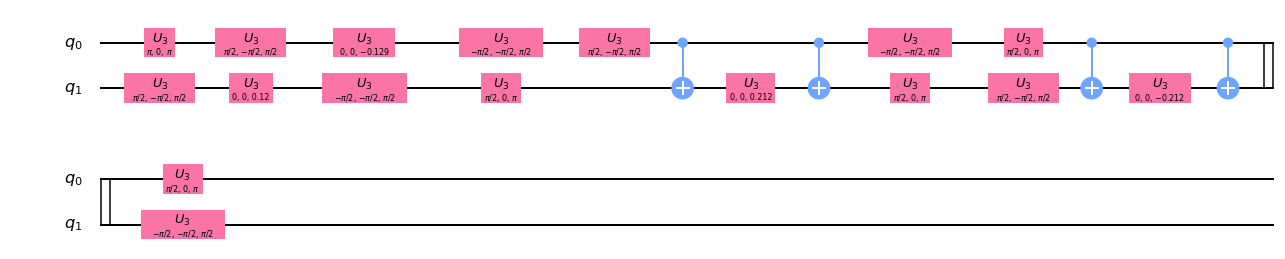

In [28]:
vqe_circ = vqe.get_optimal_circuit().decompose().decompose()
vqe_circ.draw(output = 'mpl')

In [72]:
from qiskit import ClassicalRegister

circuits = []
for line in iter(Hamiltonian.splitlines()):
    circ = vqe_circ.copy()
    for index in range(len(line)):
        op = line[index]
        if(op == "X"): 
            circ.x(index)
        elif(op == "Y"):
            circ.y(index)
        elif(op == 'Z'): 
            circ.z(index)
    c = ClassicalRegister(2)
    circ.add_register(c)
    circ.measure([0], [0])
    circ.measure([1],[1])
    circuits.append(circ)

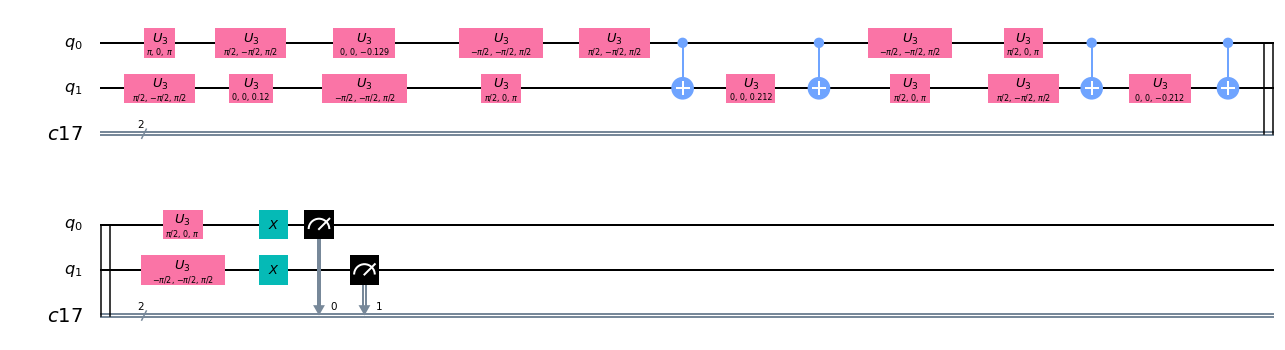

In [73]:
#Sanity check .... fifth hammy is XX
circuits[4].draw(output = 'mpl')

### Twirling Each of these hammyfied circuits 512 times

In [74]:
# 5 noise scalings 
scale = 5
lots_scaled_circuits = []

for c in range(1, scale+1):
    scale_circs = []
    print('------------------------------Starting Scale: ' +str(c) + ' ---------------------')
    
    for hammyfied_circ in circuits: 
        hammyfied_circs = []
        print( "Starting Hammified Circ")
        for i in range(512):
            #debugg 
            if (i%50 == 0): 
                print(str(i) + ' circuits done')
            circ = hammyfied_circ.copy()
            circ = create_Paulitwirled_and_noiseamplified_circuit(circ,c,two_error_map)
            hammyfied_circs.append(circ)
        scale_circs.append(hammyfied_circs)
    lots_scaled_circuits.append(scale_circs)
    
    

------------------------------Starting Scale: 1 ---------------------
Starting Hammified Circ
0 circuits done
50 circuits done
100 circuits done
150 circuits done
200 circuits done
250 circuits done
300 circuits done
350 circuits done
400 circuits done
450 circuits done
500 circuits done
Starting Hammified Circ
0 circuits done
50 circuits done
100 circuits done
150 circuits done
200 circuits done
250 circuits done
300 circuits done
350 circuits done
400 circuits done
450 circuits done
500 circuits done
Starting Hammified Circ
0 circuits done
50 circuits done
100 circuits done
150 circuits done
200 circuits done
250 circuits done
300 circuits done
350 circuits done
400 circuits done
450 circuits done
500 circuits done
Starting Hammified Circ
0 circuits done
50 circuits done
100 circuits done
150 circuits done
200 circuits done
250 circuits done
300 circuits done
350 circuits done
400 circuits done
450 circuits done
500 circuits done
Starting Hammified Circ
0 circuits done
50 circuits do

In [75]:
#Firing up noisy sim 
from qiskit.aqua import QuantumInstance
##Simulate noise of IBMQ yorktown 
##noisy_sim = QuantumInstance(backend=simulator, noise_model=noise_model )
# Get coupling map from backend
coupling_map = machine.configuration().coupling_map
# Get basis gates from noise model
basis_gates = noise_model.basis_gates



## Running Those Circs on Noisy Simulator 

### Not values but results

#### Expectation Values


In [77]:
def binaryToDecimal(binary):  
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal

In [83]:
def get_expec_val(results):
    keys = results.get_counts().keys()
    e_val = 0
    for key in keys:
        key_val = int(key)
        key_dval = int(binaryToDecimal(key_val))
        # 00 and 11 are +1 eigenvalues and others are -1
        if (key_dval == 0 or key_dval == 3):
            e_val += (int(results.get_counts()[key])/1024)
        else:
            e_val += (-1)*(int(results.get_counts()[key])/1024)
    return e_val
    

### Running the Circuits

In [84]:
from qiskit import execute 
from qiskit.compiler import transpile 

lots_scaled_values = []
for scale_circs in lots_scaled_circuits:
    print('------------------------------Starting Scale ---------------------')
    scale_values = []
    for hammyfied_circs in scale_circs:
        print( "Starting Hammified Circs")
        hammyfied_values = []
        for circ in hammyfied_circs: 
            circ = transpile(circ, basis_gates = basis_gates)
            job =  execute(circ, simulator,
                     coupling_map=coupling_map,
                     basis_gates=basis_gates,
                     noise_model=noise_model, shots = 1024)
            result = job.result()
            expec_val = get_expec_val(result)
            hammyfied_values.append(expec_val)
        scale_values.append(hammyfied_values)
    lots_scaled_values.append(scale_values)

------------------------------Starting Scale ---------------------
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
------------------------------Starting Scale ---------------------
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
------------------------------Starting Scale ---------------------
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
------------------------------Starting Scale ---------------------
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
------------------------------Starting Scale ---------------------
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs
Starting Hammified Circs


In [85]:
#convert results to expectation values
lots_scaled_values[0][0]

[-0.810546875,
 -0.82421875,
 -0.822265625,
 -0.8359375,
 -0.822265625,
 -0.830078125,
 -0.80078125,
 -0.849609375,
 -0.787109375,
 -0.84765625,
 -0.814453125,
 -0.826171875,
 -0.833984375,
 -0.81640625,
 -0.830078125,
 -0.853515625,
 -0.84375,
 -0.86328125,
 -0.80859375,
 -0.8515625,
 -0.841796875,
 -0.80859375,
 -0.861328125,
 -0.822265625,
 -0.794921875,
 -0.798828125,
 -0.802734375,
 -0.8203125,
 -0.810546875,
 -0.837890625,
 -0.85546875,
 -0.83203125,
 -0.794921875,
 -0.8125,
 -0.84765625,
 -0.818359375,
 -0.830078125,
 -0.826171875,
 -0.830078125,
 -0.8046875,
 -0.8359375,
 -0.833984375,
 -0.86328125,
 -0.822265625,
 -0.822265625,
 -0.8203125,
 -0.82421875,
 -0.822265625,
 -0.822265625,
 -0.8046875,
 -0.7890625,
 -0.791015625,
 -0.830078125,
 -0.826171875,
 -0.841796875,
 -0.796875,
 -0.80859375,
 -0.837890625,
 -0.82421875,
 -0.8203125,
 -0.8125,
 -0.8046875,
 -0.83203125,
 -0.8203125,
 -0.828125,
 -0.791015625,
 -0.806640625,
 -0.84375,
 -0.814453125,
 -0.8125,
 -0.8203125,
 -0

In [86]:
lots_scaled_expec_vals = []
for scale_values in lots_scaled_values:
    scale_expec_vals = []
    for s in range(512):
        exp_val = 0
        for h in range(len(Hamiltonian_weights)):
            exp_val += (Hamiltonian_weights[h])*(scale_values[h][s])
        scale_expec_vals.append(exp_val)
    lots_scaled_expec_vals.append(scale_expec_vals)

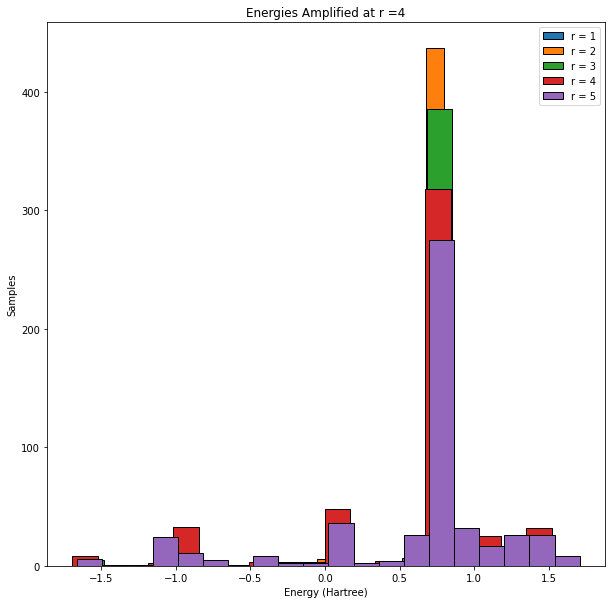

In [100]:
plt.figure(figsize= [10,10])
for r in range(1, 6):
    plt.hist(lots_scaled_expec_vals[r-1],  edgecolor = 'black',
             bins = int(0.2/0.01), label = 'r = ' + str(r))
# Add labels

plt.title('Energies Amplified at r =' + str(r-1))
plt.xlabel('Energy (Hartree)')
plt.legend()
plt.ylabel('Samples')
plt.show()

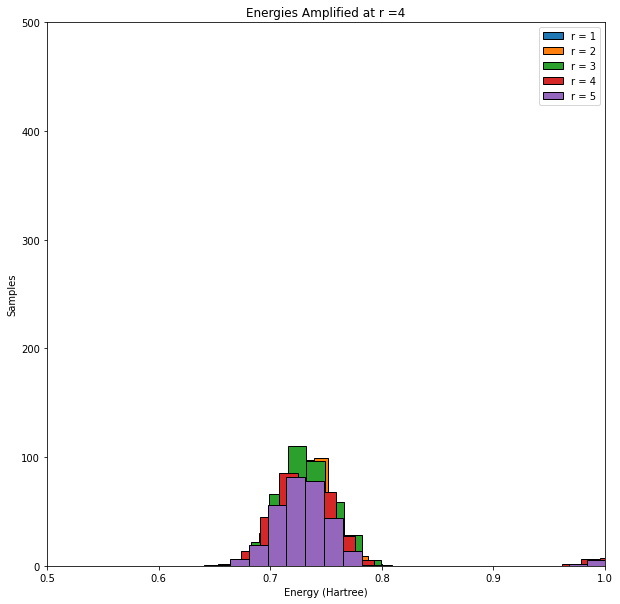

In [103]:
plt.figure(figsize= [10,10])
plt.axis([0.5, 1, 0, 500])
for r in range(1, 6):
    plt.hist(lots_scaled_expec_vals[r-1],  edgecolor = 'black',
             bins = int(0.2/0.001), label = 'r = ' + str(r))
# Add labels

plt.title('Energies Amplified at r =' + str(r-1))
plt.xlabel('Energy (Hartree)')
plt.legend()
plt.ylabel('Samples')
plt.show()

In [88]:
import numpy as np
#Finding means 
means = []
for scale_expec_vals in lots_scaled_expec_vals:
    mean = np.mean(scale_expec_vals)
    means.append(mean)


Text(0.5, 1.0, 'Amplifying error via pauli conjugation in a VQE circuit of H2 --Yorktown noise simulated')

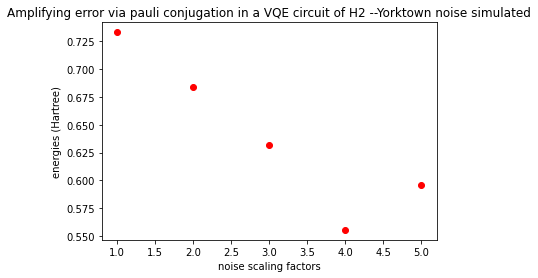

In [89]:
import matplotlib.pyplot as plt 
plt.plot([1,2,3,4,5], means, 'ro')
plt.xlabel('noise scaling factors')
plt.ylabel('energies (Hartree)')
plt.title('Amplifying error via pauli conjugation in a VQE circuit of H2 --Yorktown noise simulated')

In [92]:
shift

0.7151043390810812

In [94]:
result = ExactEigensolver(qubitOp).run()
exact_energy = result['energy'] + shift
result['energy']

-1.852388173569582